In [3]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from typing import Tuple

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind")

def cscale(rgba: Tuple[float, float, float, float], m: float) -> Tuple[float, float, float, float]:
    return (rgba[0] * m, rgba[1] * m, rgba[2] * m, rgba[3])


def cmap_extreme(map: colors.Colormap, min=0, max=1) -> colors.Colormap:
    class Wrap(colors.Colormap):
        def __init__(self, cmap: colors.Colormap):
            self.cmap = cmap
        def __getattr__(self, name):
            if name == "cmap": return self.cmap
            return getattr(self.cmap, name)
        def __eq__(self, other):
            self.cmap.__eq__(other)
        def __copy__(self):
            Wrap(self.cmap.__copy__())
        def __call__(self, X, alpha=None, bytes=False):
            if isinstance(X, np.ndarray):
                X = X - (X <= min) + (X >= max)
            if isinstance(X, float) or isinstance(X, int):
                if X <= min:
                    return self.cmap(X - 1.0, alpha, bytes)
                if X >= max:
                    return self.cmap(X + 1.0, alpha, bytes)
            return self.cmap(X, alpha, bytes)

    return Wrap(map.with_extremes(
        under=cscale(map(-1.0), 0.5), over=cscale(map(2.0), 0.5)))

def parse_frag(file: Path) -> pd.DataFrame:
    raw = file.read_text()
    data = ""
    for line in raw.splitlines():
        data += line + ((len(line) + 31) // 32 * 32 - len(line)) * "0"
    huge_pages = len(data)
    out = np.zeros(huge_pages)
    for i, char in enumerate(data):
        level = int(char)
        assert(0 <= level <= 9)
        out[i] = float(level)
    # out = out.reshape(((huge_pages + 31) // 32, 32))
    return pd.DataFrame(out)


Matplotlib is building the font cache; this may take a moment.


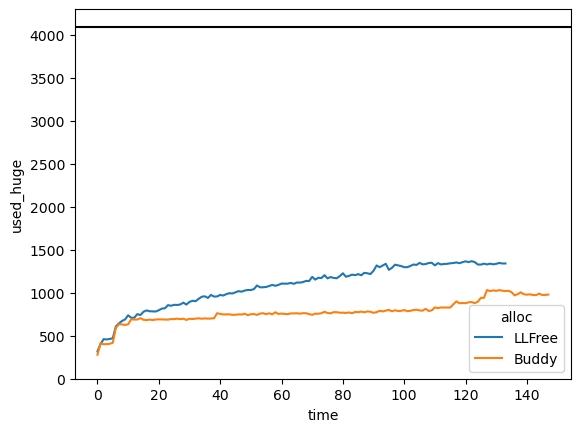

In [2]:
# LLFree, 8G, 8C
max_huge = 8*1024**3 / (2*1024**2)
ll = Path("compiling/240305-095224-ll/out_0.csv")
ll = pd.read_csv(ll, header=None, names=["small", "huge"])
ll["used_huge"] = max_huge - ll["huge"]
ll["alloc"] = "LLFree"
ll["time"] = ll.index

bu = Path("compiling/240229-163446-bu/out_0.csv")
bu = pd.read_csv(bu, header=None, names=["small", "huge"])
bu["used_huge"] = max_huge - bu["huge"]
bu["alloc"] = "Buddy"
bu["time"] = bu.index
data = pd.concat([ll, bu])

p = sns.lineplot(data=data, x="time", y="used_huge", hue="alloc")
p.set_ylim(0, max_huge * 1.05)
p.axhline(y=max_huge, xmin=0, xmax=len(data), color="black")


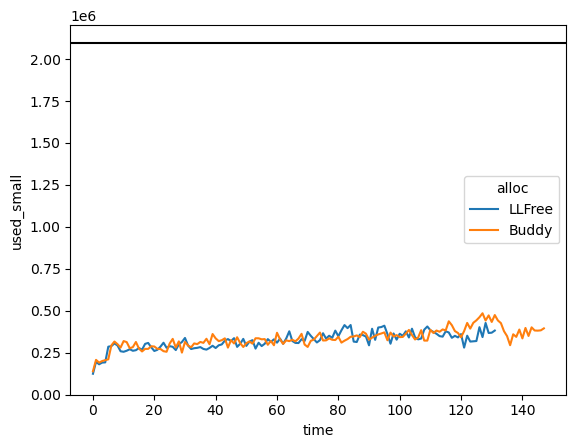

In [4]:
# LLFree, 8G, 8C
max_small = 8*1024**3 / (4*1024)
ll = Path("compiling/240229-163126-ll/out_0.csv")
ll = pd.read_csv(ll, header=None, names=["small", "huge"])
ll["used_small"] = max_small - ll["small"]
ll["alloc"] = "LLFree"
ll["time"] = ll.index

bu = Path("compiling/240229-163446-bu/out_0.csv")
bu = pd.read_csv(bu, header=None, names=["small", "huge"])
bu["used_small"] = max_small - bu["small"]
bu["alloc"] = "Buddy"
bu["time"] = bu.index
data = pd.concat([ll, bu])

p = sns.lineplot(data=data, x="time", y="used_small", hue="alloc")
p.set_ylim(0, max_small * 1.05)
p.axhline(y=max_small, xmin=0, xmax=len(data), color="black")


invalid literal for int() with base 10: 'e'
invalid literal for int() with base 10: 's'
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195]


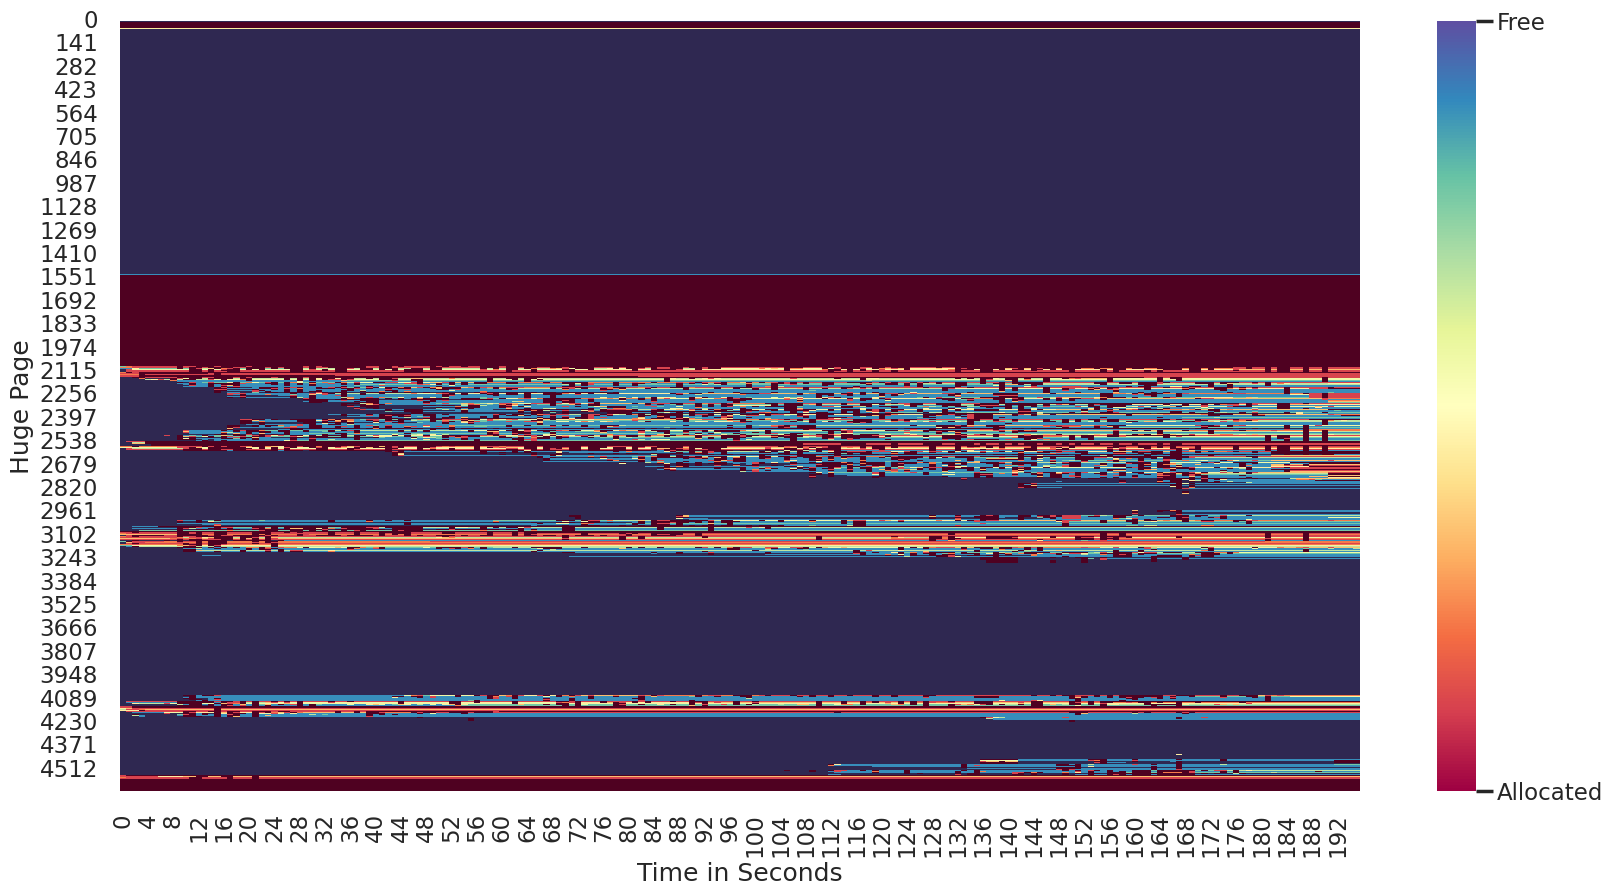

In [10]:
root = Path("compiling/240319-155814-ll")

cmap = cmap_extreme(sns.color_palette("Spectral", as_cmap=True, n_colors=10))

data = {}
for file in root.glob("frag_0_*.txt"):
    try:
        i = int(file.stem[7:])
        data[i] = parse_frag(file)
    except Exception as e:
        print(e)
        pass
print(sorted(data.keys()))

frames = []
for i, frame in sorted(list(data.items()), key=lambda x: x[0]):
    frames.append(frame)
data = pd.concat(frames, axis=1, ignore_index=True)
data *= 512 / 9

fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(10)
fix.set_facecolor("white")
p = sns.heatmap(data, ax=ax, cmap=cmap)
p.set_xlabel("Time in Seconds")
p.set_ylabel("Huge Page")

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 512])
colorbar.set_ticklabels(["Allocated", "Free"])